# Step 1: mechanics with Euler-Lagrange

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [3]:
init_vprinting()

In [17]:
m0, m1, l0, l1, t, g = symbols('m_0 m_1 l_0 l_1 t g')

In [5]:
the1, the2 = dynamicsymbols('theta_1 theta_2')
the1, the2

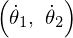

In [11]:
thedot1 = the1.diff(t)
thedot2 = the2.diff(t)
thedot1, thedot2

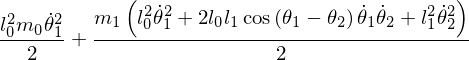

In [15]:
T = m0*l0**2*thedot1**2/2 + m1*(l0**2*thedot1**2 + l1**2*thedot2**2 + 2*l0*l1*thedot1*thedot2*cos(the2-the1))/2
T

In [19]:
U = -m0*g*cos(the1)*l0 - m1*g*(l0*cos(the1)+l1*cos(the2))
U

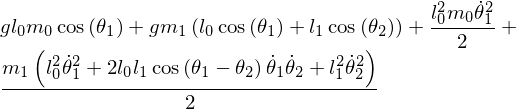

In [20]:
L = T-U
L

In [29]:
def lagrange(expr, var):
    vardot = var.diff(t)
    lag1 = expr.diff(vardot).simplify().diff(t).simplify()
    lag2 = expr.diff(var).simplify()
    lag = lag1-lag2
    return lag.simplify()

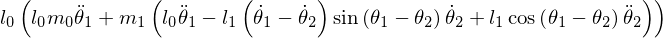

In [25]:
L.diff(thedot1).simplify().diff(t).simplify()

In [26]:
L.diff(the1)

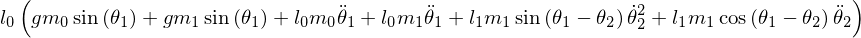

In [30]:
lagrange(L, the1)

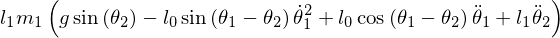

In [31]:
lagrange(L, the2)

# Step 2: conversion?